In [1]:
from collections import Counter
from itertools import product
import math

import heapq
import matplotlib.pyplot as plt
import graphviz as gv
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML

from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
np.random.seed(1)

# Huffman Coding
This notebook implements Huffman Coding and measures the compression rate versus information entropy.

## Generate our string of `h` and `t` from an unfair coin.

In [2]:
PHEADS = .8
NUMFLIPS = 2048
BLOCK_SIZE = 4

In [3]:
message = np.random.choice(['t', 'h'], NUMFLIPS, p=[1-PHEADS, PHEADS])
message = ''.join(map(str, message))
message

'hhthttthhhhhhhthhhtthhhhhhttththhhhhhhthhhhhthhhhtthhhhththhthhhthhhhhhtthhthhhhhhhhhhhhhhthhhhhhhthhhhhhhthhhtthhthhhhtttthhhhhthhhhthhhhhhhttttthhhtthhhhhthhhhhhhttthhhhhhhhhhhthhhhthhthhhhthhhhthhhhhhhhhhhhhhhttththhtththhhhhhhhhhhhhthhhhhhthhthhhthhhhhhhhhhhhhhhhhhhhhhhhhthhhhhhhhhhhhhhhhhhthththhhhthhhhhhhhtthhhhhhhhthhthhhthhhhthhhhhhhhthhhhthhhhhhhhhhhthhhhhhhthtththhhhthhhhhhhhthhhhthhhhhhhhthhhhhththhhhhhhhhtttthtthhhhhhhhhhththththhhhttthhhhhhhhtththhhhhhhhhhhhthhthhhhhhhhthhhhhhhhhhhhthhthhhthhhhthhhhthhhhhhhttthhhthhhhhhthhhhhtthhhhhhhhthhhhtthhthhhhhthhhhhhhhhhhthhhhhhhhhhhhhtthtthhthhhhhhhhhhhththhhththhhhhhhhhhhhththhthhhhththhhthththththhthhhhththhhhhhhthhhhhhhhhhhhthhhthhhhhthhhhhhhhhhhhhhhhhhthhhhhhhthhhthhhhhhhththhthhhhhhthhhhhhhhthhttthhhhhhhhhththhhhhhhhhhhhhhhhhhhhhhhthhhhhhhhthhhhththhhhhhhhhthhhhtthhthhhthhhhhhthhhhhthhhhthhhhhhhhhthtththththhhthhhhhthhhhhhhhhhhhhhthhhhthththhhhhhhhththhhhhhhththhhthhhtthhthhhthhhtttthhhhhhhhtthhhhhhhhhhhhhhtthhhhhthhhhhhhhhhh

## Generate symbols for given block size
Create a distribution for different symbols given our BLOCK_SIZE

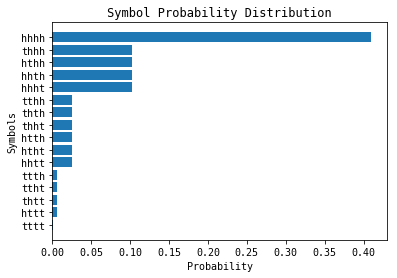

In [4]:
def symbol_probability(symbol):
    frequencies = Counter(symbol)
    num_heads = frequencies.get('h', 0)
    num_tails = frequencies.get('t', 0)
    return PHEADS ** num_heads * (1-PHEADS) ** num_tails

symbols = [''.join(symbols) for symbols in product(*[['h', 't']]*BLOCK_SIZE)]
distribution = {symbol: symbol_probability(symbol) for symbol in symbols}

symbols, probabilities = list(zip(*sorted(distribution.items(), key=lambda item:item[1])))
plt.barh(range(0, len(symbols)), probabilities, tick_label=symbols)
plt.title('Symbol Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Symbols')
plt.show()

## Huffman Coding
Implement Huffman Coding to map symbols to binary encoding given their probability.

In [5]:
heap = [(probability, [[symbol, '']]) for symbol, probability in distribution.items()]
heapq.heapify(heap)
while len(heap) > 1:
    (lprob, lnode) = heapq.heappop(heap)
    (rprob, rnode) = heapq.heappop(heap)
    lnode = [[symbol, '0'+path] for symbol, path in lnode]
    rnode = [[symbol, '1'+path] for symbol, path in rnode]
    combined = (lprob + rprob, lnode + rnode)
    heapq.heappush(heap, combined)
encoding = dict(heap[0][1])

In [6]:
symbols = list(encoding.keys())
encodings = [encoding[symbol] for symbol in symbols]
probabilities = [distribution[symbol] for symbol in symbols]
df = pd.DataFrame({
    'Probability': probabilities, 
    'Encoding': encodings,
}, index=pd.Series(symbols, name='Symbol'))
df = df.sort_values('Probability', ascending=False)
df.style.format({'Probability': '{:.2%}'.format})

,Probability,Encoding
Symbol,,
hhhh,40.96%,0
hthh,10.24%,100
thhh,10.24%,101
hhht,10.24%,1110
hhth,10.24%,1111
hhtt,2.56%,110010
htht,2.56%,110011
htth,2.56%,110100
thht,2.56%,110101


## Encode our message
Use the encoding to compress our message

In [7]:
blocks = [message[offset:offset+BLOCK_SIZE] for offset in range(0, len(message), BLOCK_SIZE)]
encoded_blocks = [encoding[block] for block in blocks]
''.join(encoded_blocks)

'111111000100111111001001100101101100111101011101001110100101101111011010100011110111101111110010111111101100010010110001100011111011111010001010110001000111111101111111001010001100010110101110110000101111011111111000000101000111011001101010110100011101111111111100010110000100011001111011011100010110001111011011000110001101101000011001111001101100010011101101100011101111011100001101011110010110001100011111100111101101110111111101101010100001000011101100000111100111110111011000111010010111001111101100111100111111111010001000011111111010100011100111011100111010010111100011010111011101110100000001000111111101000111001101111011011110010011110011000001100111001001110000111111101100110011011001111101101110111101101110001100011011100011011111100000111110111001011011001001111110101100101001000110100011110011101110101010111011001110111111010110000111001010100111101101001011001101110001110100100010111101101101110001101101100101110100000111010101010110110111011101010111000111000111010010010100011

## Measure the compression efficiency
Calculate how well Huffman Encoding compressed the message versus the theoretical maximum compressed length
calculated using information entropy

In [8]:
entropy = PHEADS * np.log2(1/PHEADS) + (1-PHEADS) * np.log2(1/(1-PHEADS))
compressed_entropy = int(len(message) * entropy)
compressed_actual = len(''.join(encoded_blocks))
efficiency = compressed_entropy / compressed_actual
efficiency

0.9959568733153639